# <center> Machine and Deep Learning Term Project <center>
# <center> Image Classification Task on Fashion-MNIST Dataset <br>
**Can Abdullah Camuz** <br>
**2041519**<br>
**canabdullah.camuz@studenti.unipd.it**

# Fashion-MNIST Dataset Introduction
* Fashion-MNIST is a dataset of Zalando Company's article images, consisting of a training set of 60,000 examples and a test set of 10,000 examples. 
* Each example is a 28x28 grayscale image, associated with a label from 10 classes. 
* Zalando intends Fashion-MNIST to serve as a direct drop-in replacement for the original MNIST dataset for benchmarking machine learning algorithms. 
* It shares the same image size and structure of training and testing splits. 

In this project, I will employ different algorithms (models) learned in the scope of the course. I will run them on the dataset, measure the success of each, evaluate the predictions and finally use some visualization tools to understand how the parameters change for each model.

# 1) Importing the Necessary Libraries

In [1]:
from urllib.request import urlopen #to load the data from web

# Handle data and matrices, doing math operations :
import numpy as np
import pandas as pd
import math 

# Modelling Algorithms :

# Classification
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier


# Regression
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor 
from sklearn.neighbors import KNeighborsRegressor

# Modelling Helpers :
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV , KFold , cross_val_score


#Evaluation metrics :

# Classification
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score

# Neural Network Libraries
import tensorflow as tf
from keras.layers import Dense
from tensorflow.keras.models import Sequential #import the type of mpdel: sequential (e.g., MLP)
from tensorflow.keras.layers import Flatten, Dense #simple linear layer
from tensorflow.keras.utils import to_categorical # transformation for classification labels
from keras.utils.vis_utils import plot_model
from tensorflow.python.framework.random_seed import set_random_seed
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import TensorBoard,EarlyStopping
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import SGD, Adagrad, Adadelta, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.python.framework.random_seed import set_random_seed
from tensorflow.keras.callbacks import LearningRateScheduler

# Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# 2) Exploring The Dataset

## 2.1) Loading the Dataset

In [2]:
def load_fashion_mnist():

    url_base = "https://www.math.unipd.it/~dasan/"
    Y_trainval = np.frombuffer(urlopen(url_base + "train-labels-idx1-ubyte").read(), dtype=np.uint8, offset=8)
    X_trainval = np.frombuffer(urlopen(url_base + "train-images-idx3-ubyte").read(), dtype=np.uint8, offset=16).reshape(len(Y_trainval), 784) 
    # besides loading the data, I flattened it into a vector
    
    Y_test = np.frombuffer(urlopen(url_base + "t10k-labels-idx1-ubyte").read(), dtype=np.uint8, offset=8)
    X_test = np.frombuffer(urlopen(url_base + "t10k-images-idx3-ubyte").read(), dtype=np.uint8, offset=16).reshape(len(Y_test), 784)

    return X_trainval, Y_trainval, X_test, Y_test


In [3]:
#Creating our sets which we will use for the models
X_trainval, Y_trainval, X_test, Y_test = load_fashion_mnist()

## 2.2) Data and Features Introduction
The images are actually 2D arrays of numbers, known as pixels. Computers classify images based on boundaries and curves of the object represented by pixel values.

Labels are our target variable. We can consider different labels as different classes. In this project, classes are items.

The images in our dataset consist of greyscale pixels.

Here is some of the items in the original dataset. This is how the Labels and the Dataset looks like.

![Imgur](https://i.imgur.com/coDqChv.png)

In [4]:
#Let's print the sizes of our sets: train and test

print('Train & Val: ', X_trainval.shape, Y_trainval.shape)
print('Test: ', X_test.shape, Y_test.shape)

Train & Val:  (60000, 784) (60000,)
Test:  (10000, 784) (10000,)


In [5]:
#see the number of labels
labels = set(Y_trainval)
print(labels, len(labels))

# Configuration options
feature_vector_length = X_trainval.shape[1] #how many features
num_classes = len(labels) #how many classes

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9} 10


* So, there are 60,000 Training Samples and 10,000 Test Samples.
* The reason of getting 784 columns is that each example is a 28x28 grayscale image.
* Each image is associated with a label from 10 classes.
* Each pixel has a value associated with it, indicating the lightness or darkness of that pixel, an integer between 0 and 255 with higher numbers meaning darker.

Below, an example of the images is visualized by plotting a random image

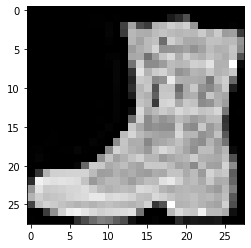

In [6]:
image = X_trainval[150,:].reshape((28, 28)) #reverse operation of flattening the 24*24 pixels
#I want to see the 150th article of clothing

plt.imshow(image, cmap='gray', vmin=0, vmax=255) #plotting the pixels grayscale
plt.show()

# 3) Data Preperation

## 3.1) Setting Random Seeds

Random numbers are used to select data and configure the starting weights in a model. Here, I will keep the random seed constant for all my trials, this removes the variation due to this randomness, making it easier to interpret the effects of change in hyper parameter values.


In [7]:
np.random.seed(123)
set_random_seed(2)

## 3.2) Normalization

The Pixel Values are stored as __*Integer*__ values in the range 0 to 255, the range that a single 8-bit byte can offer.
They need to be scaled down to [0,1] in order to Optimization Algorithms to work much faster. Here, we acheive Zero Mean and Unit Variance.

We need a preparation that aims to facilitate the network optimization process and maximize the probability of obtaining good results.

Normalizing a vector (in this case our pixel data) is dividing data to the vector norm. Typically we use it to obtain the Euclidean distance of the vector equal to a certain predetermined value, through the transformation below, called min-max normalization:

> x = (x - min) / (max - min) ; Here min=0 and max=255

In [8]:
X_trainval = X_trainval.astype('float32') / 255
X_test = X_test.astype('float32') / 255

## 3.3) Splitting Data into Train and Validation Set
Now it is time to extract validation set from the training data. Validation set will be used for evaluating the performance of our model before we proceed to compare the outputs with the test set.

Extraction will be made by using the train_test_split method of scikit learn library.

In [9]:
X_train, X_val, Y_train, Y_val = train_test_split(
    X_trainval, Y_trainval, test_size=0.2, shuffle=False
)
#80% of the data will be in the training set, the remaining 20% will belong to validation

<a id="there_you_go_4"></a>
# 4) Training a Neural Network

<a id="there_you_go_4.1"></a>
## 4.1) Building a Neural Network

My Neural Network will consist of 2 hidden layers, each containing 128 nodes (neurons). Since there are 10 classes (labels), output layer will contain 10 nodes.

* In the model **Sequential Keras API** will be used, which is just a linear stack of layers. I add one layer at a time starting from input.

* Next I add **Hidden Layers**, which are used for a layer in between input layers and output layers, where artificial neurons take in a set of weighted inputs and produce an output through an activation function.

 > As an activation function I used **ReLU** for the hidden layers, which is a piecewise linear function that will output the input directly if it is positive, otherwise, it will output zero.

* Then I add the **Output Layer**. It has units equal to the number of classes to be identified. Here, **Softmax** function is used for Multi-Class Classification.

In [10]:
model_neural_netwok = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

## 4.2) Compiling the Model

Now the model needs to be compiled. For this, we must select some parameters for the model. As an optimizer, "Adam" is a method for efficient stochastic optimization that only requires first-order gradients with little memory requirement.

Then, we select the loss function for the neural network which we want to minimize. "sparse_categorical_crossentropy" is used in multiclass classification when your classes are mutually exclusive which means that each sample belongs exactly to one class, such as our case. Using sparse_categorical_crossentropy saves time and memory because it simply uses a single integer for a class, rather than a whole vector.

Finally, accuracy will be used to evaluate our model's performance.

 > Learning Rate Decay
 Learning rate decay is a technique for training neural networks. It starts training the network with a large learning rate and then slowly reducing it until local minimum is obtained. Thus it helps optimization and generalization.

Adam optimizer updates parameters with an individual learning rate. This means that every parameter in the network has a specific learning rate associated. So, the learning rates adapt themselves during training steps. So I decide not to apply Learning Rate Decay once again.

In [11]:
model_neural_netwok.compile(
    optimizer = tf.optimizers.Adam(),
    loss = tf.losses.sparse_categorical_crossentropy,
    metrics = ['accuracy']
)

## 4.3) Fitting the Model

In [12]:
history  = model_neural_netwok.fit(X_train, Y_train ,batch_size = 1200, verbose=2, epochs=28, validation_data=(X_val, Y_val))

Epoch 1/28
40/40 - 1s - loss: 1.0286 - accuracy: 0.6586 - val_loss: 0.5939 - val_accuracy: 0.7911 - 1s/epoch - 37ms/step
Epoch 2/28
40/40 - 1s - loss: 0.5302 - accuracy: 0.8155 - val_loss: 0.4900 - val_accuracy: 0.8285 - 617ms/epoch - 15ms/step
Epoch 3/28
40/40 - 1s - loss: 0.4610 - accuracy: 0.8404 - val_loss: 0.4482 - val_accuracy: 0.8421 - 635ms/epoch - 16ms/step
Epoch 4/28
40/40 - 0s - loss: 0.4302 - accuracy: 0.8504 - val_loss: 0.4254 - val_accuracy: 0.8506 - 441ms/epoch - 11ms/step
Epoch 5/28
40/40 - 1s - loss: 0.4057 - accuracy: 0.8577 - val_loss: 0.4150 - val_accuracy: 0.8533 - 577ms/epoch - 14ms/step
Epoch 6/28
40/40 - 1s - loss: 0.3828 - accuracy: 0.8656 - val_loss: 0.4008 - val_accuracy: 0.8580 - 619ms/epoch - 15ms/step
Epoch 7/28
40/40 - 1s - loss: 0.3685 - accuracy: 0.8700 - val_loss: 0.3801 - val_accuracy: 0.8653 - 620ms/epoch - 15ms/step
Epoch 8/28
40/40 - 1s - loss: 0.3563 - accuracy: 0.8740 - val_loss: 0.3866 - val_accuracy: 0.8646 - 615ms/epoch - 15ms/step
Epoch 9/28


## 4.4) Model Summary

In [13]:
model_neural_netwok.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (1200, 128)               100480    
                                                                 
 dense_1 (Dense)             (1200, 128)               16512     
                                                                 
 dense_2 (Dense)             (1200, 10)                1290      
                                                                 
Total params: 118,282
Trainable params: 118,282
Non-trainable params: 0
_________________________________________________________________


## 4.5) Plotting the Training and Validation Curves

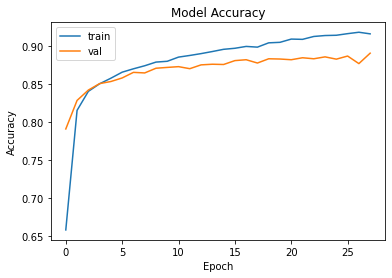

In [17]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

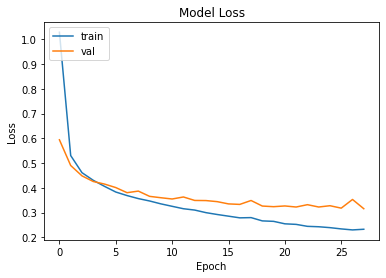

In [18]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## 4.6) Evaluating the Model

In [16]:
evaluation = model_neural_netwok.evaluate(X_test, Y_test)

print('Loss: {:.4f}'.format(evaluation[0]))
print('Accuracy: {:.4f}'.format(evaluation[1]))


313/313 [==============================] - 1s 3ms/step - loss: 0.3401 - accuracy: 0.8813
Loss: 0.3401
Accuracy: 0.8813


Depending on the accuracy score, the model looks like it did a good job on generalizing the data.

## 4.7) Confusion Matrix
A confusion matrix is a table that is often used to describe the performance of a classification model on a test set for which the true values are known.

Let's view the the Performance of our classification model on the data using Confusion Matrix.

In [19]:
from sklearn.metrics import classification_report, confusion_matrix

# Predict the values from the validation dataset
pred_nueral_network = model_neural_netwok.predict(X_test)

confusion_neural_network = confusion_matrix(Y_test, np.argmax(pred_nueral_network,axis=1))
print(confusion_neural_network)

[[859   1  11  25   4   0  94   1   5   0]
 [  3 970   0  19   3   0   3   0   2   0]
 [ 20   2 778  14  93   0  88   0   5   0]
 [ 23  14  15 883  37   1  21   0   5   1]
 [  0   0  82  33 811   2  69   0   3   0]
 [  0   0   0   1   0 959   0  25   2  13]
 [143   2  71  34  58   1 684   0   7   0]
 [  0   0   0   0   0  13   0 972   0  15]
 [  4   1   6   6   5   3   6   7 962   0]
 [  0   0   0   0   0  11   1  53   0 935]]


## 4.8) Plotting The Confusion Matrix

<AxesSubplot:title={'center':'True or False Prediction Matrix Fashion MNIST\n'}>

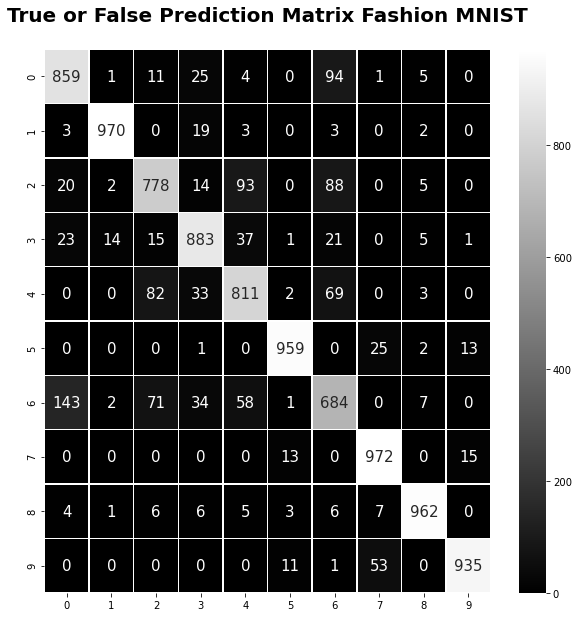

In [20]:
#To see the number of predictions for each class as a matrix

plt.figure(figsize = (10,10))
plt.title('True or False Prediction Matrix Fashion MNIST\n',fontweight='bold',fontsize=20)
sns.heatmap(confusion_neural_network,annot=True,annot_kws={'size': 15},linewidths=0.5,fmt="d",cmap="gray")

## 4.9) Classification Report

The classification report visualizer displays the precision, recall, F1, and support scores for the model.

**Precision** is the ratio of True Positives to the sum of True and False Positives.

**Recall** is the ratio of True Positives to the sum of True Positives and False Negatives.

**F1 Score** is a weighted harmonic mean of precision and recall such that the best score is 1.0 and the worst is 0.0 .

**Support** is the number of actual occurrences of the class in the specified dataset. Imbalanced support in the training data may indicate structural weaknesses in the reported scores of the classifier and could indicate the need for stratified sampling or rebalancing.

In [21]:
metrics_report_neural_network = classification_report(Y_test, np.argmax(pred_nueral_network,axis=1))
print(metrics_report_neural_network)

              precision    recall  f1-score   support

           0       0.82      0.86      0.84      1000
           1       0.98      0.97      0.97      1000
           2       0.81      0.78      0.79      1000
           3       0.87      0.88      0.88      1000
           4       0.80      0.81      0.81      1000
           5       0.97      0.96      0.96      1000
           6       0.71      0.68      0.70      1000
           7       0.92      0.97      0.94      1000
           8       0.97      0.96      0.97      1000
           9       0.97      0.94      0.95      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



# 5) Training a Decision Tree

## 5.1) Building and Fitting The Model

In [63]:
model_decision_tree = DecisionTreeClassifier(min_samples_leaf = 5, max_depth=7)

In [64]:
DECTRE = model_decision_tree.fit(X_train, Y_train)

## 5.2) Making Predictions

In [ ]:
y_train_pred_DC = model_decision_tree.predict(X_train)
y_val_pred_DC = model_decision_tree.predict(X_val)

print(f"Decision Tree.\tTrain ACC: {accuracy_score(Y_train, y_train_pred_DC)}")
print(f"Decision Tree.\tVal ACC: {accuracy_score(Y_val, y_val_pred_DC)}")

In [66]:
y_pred_DC = model_decision_tree.predict(X_test)
print(f"Decision Tree.\tTest ACC: {accuracy_score(Y_test, y_pred_DC)}")

Decision Tree.	Test ACC: 0.7593


## 5.3) Confusion Matrix

In [67]:
print(confusion_matrix(Y_test, y_pred_DC))

[[819   8  13  42  13   4  88   0  10   3]
 [ 17 922   2  48   3   1   6   0   0   1]
 [ 24   1 608   5 208   4 141   0   9   0]
 [ 70  19  26 771  42   5  62   0   5   0]
 [ 23   9 157  57 605   2 147   0   0   0]
 [  0   6   0  14   0 843   0  87  19  31]
 [231   7 124  35 129   4 447   0  22   1]
 [  0   1   0   0   0  42   0 891   4  62]
 [ 21   6   9  17  58  14  57  10 804   4]
 [  1   0   0   3   2  15   3  86   7 883]]


<AxesSubplot:title={'center':'True or False Prediction Matrix Fashion MNIST\n'}>

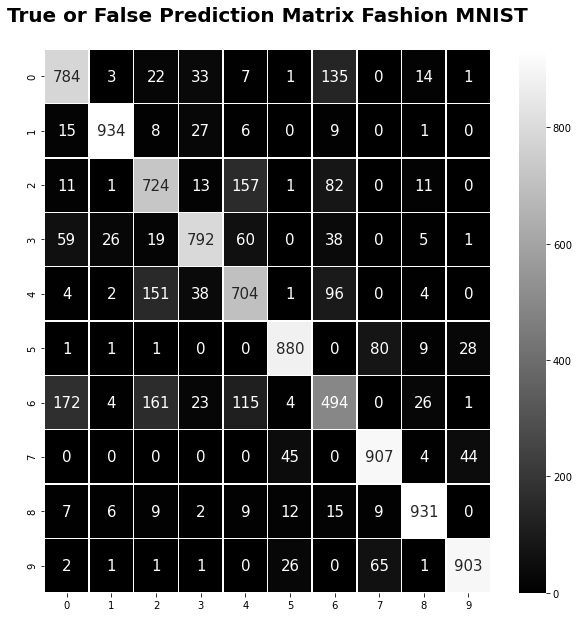

In [74]:
#To illustrate the confusion matrix

confusion_matrixDT = confusion_matrix(Y_test, y_pred_DC)
plt.figure(figsize = (10,10))
plt.title('True or False Prediction Matrix Fashion MNIST\n',fontweight='bold',fontsize=20)
sns.heatmap(confusion_matrixDT,annot=True,annot_kws={'size': 15},linewidths=0.5,fmt="d",cmap="gray")

## 5.4) Grid Search Approach

To find the best parameters in the given interval, I applied Grid Search to Decision Tree model.

In [69]:
tree_param = {'criterion':['gini','entropy'],'max_depth':[10,11,12]}
gridDT = GridSearchCV(DecisionTreeClassifier(), tree_param, cv=5)
gridDT.fit(X_trainval, Y_trainval) #we do not use the train-validation split strategy since it is included in the CV procedure

KeyboardInterrupt: 

In [57]:
# Let's see the best parameters and score
print(gridDT.best_params_)
print(gridDT.best_score_)

{'criterion': 'entropy', 'max_depth': 12}
0.81525


## 5.5) Model Rebuilding and Comparison

In [70]:
#Now, let's try with the parameters decided by grid search and run the model again

model_decision_tree_new = DecisionTreeClassifier(criterion='entropy', min_samples_leaf = 5, max_depth=12)

DECTRE_new = model_decision_tree_new.fit(X_train, Y_train)

y_train_pred_DC = model_decision_tree_new.predict(X_train)
y_val_pred_DC = model_decision_tree_new.predict(X_val)

print(f"Decision Tree.\tTrain ACC: {accuracy_score(Y_train, y_train_pred_DC)}")
print(f"Decision Tree.\tVal ACC: {accuracy_score(Y_val, y_val_pred_DC)}")

Decision Tree.	Train ACC: 0.8835208333333333
Decision Tree.	Val ACC: 0.8140833333333334


In [72]:
y_pred_DC = model_decision_tree_new.predict(X_test)
print(f"Decision Tree.\tTest ACC: {accuracy_score(Y_test, y_pred_DC)}")
print(classification_report(Y_test, y_pred_DC))

Decision Tree.	Test ACC: 0.8053
              precision    recall  f1-score   support

           0       0.74      0.78      0.76      1000
           1       0.96      0.93      0.94      1000
           2       0.66      0.72      0.69      1000
           3       0.85      0.79      0.82      1000
           4       0.67      0.70      0.68      1000
           5       0.91      0.88      0.89      1000
           6       0.57      0.49      0.53      1000
           7       0.85      0.91      0.88      1000
           8       0.93      0.93      0.93      1000
           9       0.92      0.90      0.91      1000

    accuracy                           0.81     10000
   macro avg       0.81      0.81      0.80     10000
weighted avg       0.81      0.81      0.80     10000



In [76]:
print(confusion_matrix(Y_test, y_pred_DC))

[[784   3  22  33   7   1 135   0  14   1]
 [ 15 934   8  27   6   0   9   0   1   0]
 [ 11   1 724  13 157   1  82   0  11   0]
 [ 59  26  19 792  60   0  38   0   5   1]
 [  4   2 151  38 704   1  96   0   4   0]
 [  1   1   1   0   0 880   0  80   9  28]
 [172   4 161  23 115   4 494   0  26   1]
 [  0   0   0   0   0  45   0 907   4  44]
 [  7   6   9   2   9  12  15   9 931   0]
 [  2   1   1   1   0  26   0  65   1 903]]


<AxesSubplot:title={'center':'True or False Prediction Matrix Fashion MNIST\n'}>

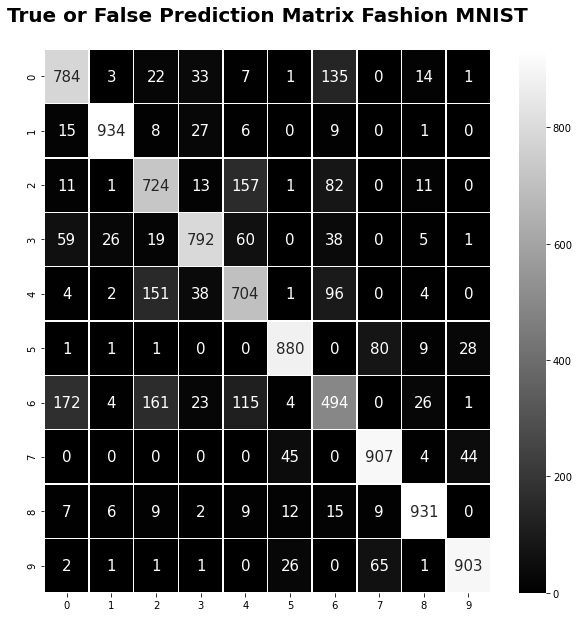

In [73]:
#To illustrate the confusion matrix

confusion_matrixDT2 = confusion_matrix(Y_test, y_pred_DC)
plt.figure(figsize = (10,10))
plt.title('True or False Prediction Matrix Fashion MNIST\n',fontweight='bold',fontsize=20)
sns.heatmap(confusion_matrixDT2,annot=True,annot_kws={'size': 15},linewidths=0.5,fmt="d",cmap="gray")

## 6) Logistic Regression

## 6.1) Model Fitting

In [77]:
LogReg_model = LogisticRegression(solver = "sag", tol=0.1, max_iter=100)
LogReg_model.fit(X_train, Y_train)

LogisticRegression(solver='sag', tol=0.1)

## 6.2) Prediction

In [78]:
#estimation (y_hat) for training and validation accuracies 

y_train_pred_lr = LogReg_model.predict(X_train)
y_val_pred_lr = LogReg_model.predict(X_val)

print(f"Logistic Regression.\tTrain ACC: {accuracy_score(Y_train, y_train_pred_lr)}")
print(f"Logistic Regression.\tVal ACC: {accuracy_score(Y_val, y_val_pred_lr)}")

Logistic Regression.	Train ACC: 0.8681875
Logistic Regression.	Val ACC: 0.8513333333333334


In [79]:
#test set prediction

y_pred_LR = LogReg_model.predict(X_test)
print(f"Logistic Regression.\tTest ACC: {accuracy_score(Y_test, y_pred_LR)}")

Logistic Regression.	Test ACC: 0.8422


## 6.3) Confusion Matrix

<AxesSubplot:title={'center':'True or False Prediction Matrix Fashion MNIST\n'}>

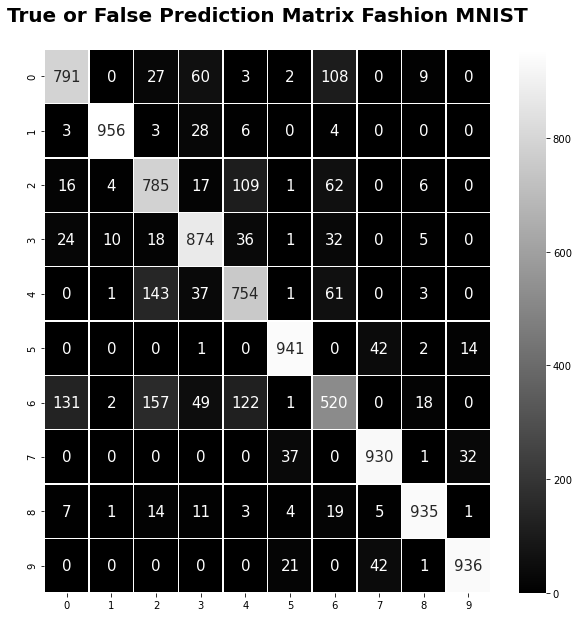

In [80]:
#To illustrate the confusion matrix

confusion_matrixLR = confusion_matrix(Y_test, y_pred_LR)
plt.figure(figsize = (10,10))
plt.title('True or False Prediction Matrix Fashion MNIST\n',fontweight='bold',fontsize=20)
sns.heatmap(confusion_matrixLR,annot=True,annot_kws={'size': 15},linewidths=0.5,fmt="d",cmap="gray")

## 6.4) Score Table

In [81]:
print(classification_report(Y_test, y_pred_LR))

              precision    recall  f1-score   support

           0       0.81      0.79      0.80      1000
           1       0.98      0.96      0.97      1000
           2       0.68      0.79      0.73      1000
           3       0.81      0.87      0.84      1000
           4       0.73      0.75      0.74      1000
           5       0.93      0.94      0.94      1000
           6       0.65      0.52      0.58      1000
           7       0.91      0.93      0.92      1000
           8       0.95      0.94      0.94      1000
           9       0.95      0.94      0.94      1000

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



## 6.5) Grid Search Approach
The first thing to do is to define a dictionary containing the hyper-parameters with the range of values we want to search on.

In [82]:
param_grid_test = {
    'C': [0.1, 0.5],
    'fit_intercept': [True, False]
}

In [83]:
#Then, we create the grid-search object

#target classifier
LogReg_model_new = LogisticRegression(solver = "sag", tol=0.1, max_iter=100)

In [84]:
#grid-search object
grid_LR = GridSearchCV(estimator= LogReg_model_new, param_grid=param_grid_test, cv = 5, scoring = "accuracy")

In [85]:
#fit the model
grid_LR.fit(X_trainval, Y_trainval) #we do not use the train - validation split strategy since it is included in the CV procedure

NameError: name 'clf' is not defined

In [86]:
#see the best parameters and performance
print(grid_LR.best_params_)
print(grid_LR.best_score_)

{'C': 0.1, 'fit_intercept': True}
0.85395


## 6.6) Model Rebuilding and Comparison

In [87]:
#Now I build the model with the best parameters again
LogReg_model2 = LogisticRegression(C=0.1, fit_intercept=True, solver = "sag", tol=0.1, max_iter=100)
LogReg_model2.fit(X_train, Y_train)

LogisticRegression(C=0.1, solver='sag', tol=0.1)

In [88]:
#getting the accuracy scores
y_train_pred_lr2 = LogReg_model2.predict(X_train)
y_val_pred_lr2 = LogReg_model2.predict(X_val)
y_pred_LR2 = LogReg_model.predict(X_test)

print(f"Logistic Regression.\tTrain ACC: {accuracy_score(Y_train, y_train_pred_lr2)}")
print(f"Logistic Regression.\tVal ACC: {accuracy_score(Y_val, y_val_pred_lr2)}")
print(f"Logistic Regression.\tTest ACC: {accuracy_score(Y_test, y_pred_LR2)}")

Logistic Regression.	Train ACC: 0.8686666666666667
Logistic Regression.	Val ACC: 0.8536666666666667
Logistic Regression.	Test ACC: 0.8422


<AxesSubplot:title={'center':'True or False Prediction Matrix Fashion MNIST\n'}>

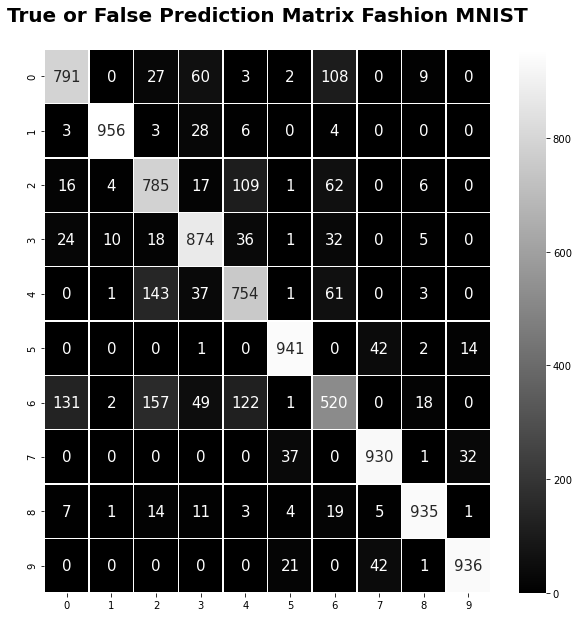

In [89]:
#To illustrate the confusion matrix

confusion_matrixLR2 = confusion_matrix(Y_test, y_pred_LR2)
plt.figure(figsize = (10,10))
plt.title('True or False Prediction Matrix Fashion MNIST\n',fontweight='bold',fontsize=20)
sns.heatmap(confusion_matrixLR2,annot=True,annot_kws={'size': 15},linewidths=0.5,fmt="d",cmap="gray")

In [90]:
# Print Classification Report

print(classification_report(Y_test, y_pred_LR2))

              precision    recall  f1-score   support

           0       0.81      0.79      0.80      1000
           1       0.98      0.96      0.97      1000
           2       0.68      0.79      0.73      1000
           3       0.81      0.87      0.84      1000
           4       0.73      0.75      0.74      1000
           5       0.93      0.94      0.94      1000
           6       0.65      0.52      0.58      1000
           7       0.91      0.93      0.92      1000
           8       0.95      0.94      0.94      1000
           9       0.95      0.94      0.94      1000

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



# 7) Random Forest

## 7.1) Model Fitting

In [97]:
model_random_forest = RandomForestClassifier(n_estimators = 25, max_depth = 12, random_state = 2) #
model_random_forest.fit(X_train, Y_train)

RandomForestClassifier(max_depth=12, n_estimators=25, random_state=2)

## 7.2) Prediction

In [98]:
#getting the accuracy scores
y_train_pred_RF = model_random_forest.predict(X_train)
y_val_pred_RF = model_random_forest.predict(X_val)
y_pred_RF = model_random_forest.predict(X_test)

print(f"Random Forest.\tTrain ACC: {accuracy_score(Y_train, y_train_pred_RF)}")
print(f"Random Forest.\tVal ACC: {accuracy_score(Y_val, y_val_pred_RF)}")
print(f"Random Forest.\tTest ACC: {accuracy_score(Y_test, y_pred_RF)}")

Random Forest.	Train ACC: 0.921875
Random Forest.	Val ACC: 0.8616666666666667
Random Forest.	Test ACC: 0.8515


## 7.3) Confusion Matrix and Score Table

In [95]:
print(confusion_matrix(Y_test, pred_random_forest))

[[846   0  13  31   4   1  92   0  13   0]
 [  2 954   2  28   3   0  10   0   1   0]
 [ 10   0 805  10 109   0  61   0   5   0]
 [ 20   4  11 904  31   0  28   0   2   0]
 [  1   1  96  38 812   0  48   0   4   0]
 [  0   0   0   1   0 954   0  31   2  12]
 [149   1 127  29  93   0 579   0  22   0]
 [  0   0   0   0   0  15   0 943   0  42]
 [  0   2   2   2   5   2  10   5 971   1]
 [  0   0   0   0   0   7   1  42   2 948]]


In [96]:
print(classification_report(Y_test, pred_random_forest))

              precision    recall  f1-score   support

           0       0.82      0.85      0.83      1000
           1       0.99      0.95      0.97      1000
           2       0.76      0.81      0.78      1000
           3       0.87      0.90      0.88      1000
           4       0.77      0.81      0.79      1000
           5       0.97      0.95      0.96      1000
           6       0.70      0.58      0.63      1000
           7       0.92      0.94      0.93      1000
           8       0.95      0.97      0.96      1000
           9       0.95      0.95      0.95      1000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000

